In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(455)
np.random.seed(455)

In [2]:
# Read dataset
dataset = pd.read_csv("C:/My_Programs/Python/Mastercard Stock Prediction LSTM/Mastercard_stock_history.csv", index_col="Date", parse_dates=["Date"]).drop(["Dividends", "Stock Splits"], axis=1)
#dataset = pd.read_csv("C:/My_Programs/Python/Mastercard Stock Prediction LSTM/Mastercard_stock_history.csv", index_col="Date")

print(dataset.head())

                Open      High       Low     Close     Volume
Date                                                         
2006-05-25  3.748967  4.283869  3.739664  4.279217  395343000
2006-05-26  4.307126  4.348058  4.103398  4.179680  103044000
2006-05-30  4.183400  4.184330  3.986184  4.093164   49898000
2006-05-31  4.125723  4.219679  4.125723  4.180608   30002000
2006-06-01  4.179678  4.474572  4.176887  4.419686   62344000


In [3]:
# Data Analysis
dataset.describe()

,Open,High,Low,Close,Volume
count,3872.000000,3872.000000,3872.000000,3872.000000,3.872000e+03
mean,104.896814,105.956054,103.769349,104.882714,1.232250e+07
std,106.245511,107.303589,105.050064,106.168693,1.759665e+07
min,3.748967,4.102467,3.739664,4.083861,6.411000e+05
25%,22.347203,22.637997,22.034458,22.300391,3.529475e+06
50%,70.810079,71.375896,70.224002,70.856083,5.891750e+06
75%,147.688448,148.645373,146.822013,147.688438,1.319775e+07
max,392.653890,400.521479,389.747812,394.685730,3.953430e+08


In [4]:
#Sum null values
dataset.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

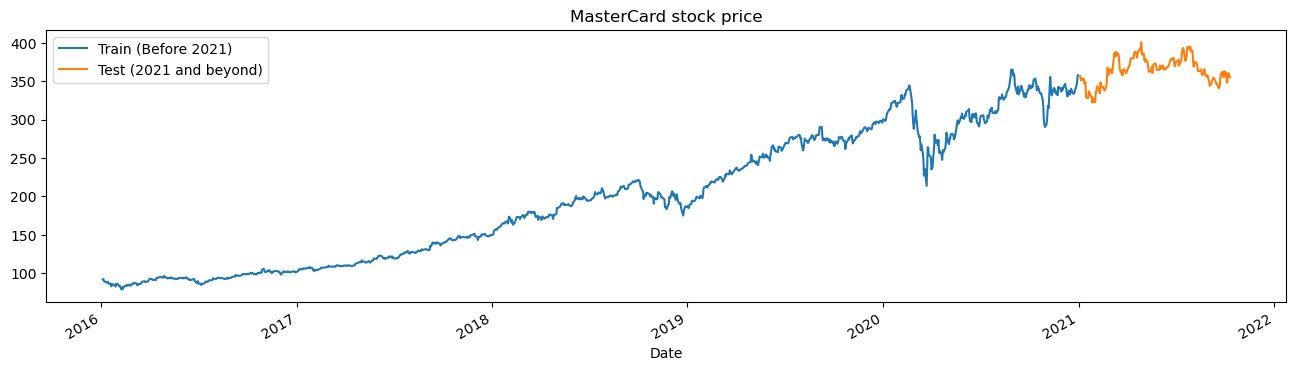

In [5]:
#MasterCard stock prices have been on the rise since 2016. 
#It had a dip in the first quarter of 2020 but it gained a stable position in the latter half of the year. 
#Our test dataset consists of one year, from 2021 to 2022, and the rest of the dataset is used for training 

tstart = 2016
tend = 2020

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("MasterCard stock price")
    plt.show()

train_test_plot(dataset,tstart,tend)

In [6]:
#Data Preprocessing
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"].values
    test = dataset.loc[f"{tend+1}":, "High"].values
    return train, test

training_set, test_set = train_test_split(dataset, tstart, tend)

In [7]:
#Use MinMaxScaler function to standardize our training set
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [8]:
#The split_sequence function uses a training dataset and converts it into inputs (X_train) and outputs (y_train).
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 60
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [9]:
print(X_train.shape)
print(y_train.shape)

(1199, 60, 1)
(1199, 1)


In [10]:
#We are working with univariate series, so the number of features is one, and 
#we need to reshape the X_train to fit on the LSTM model. 
#The X_train has [samples, timesteps], and we will reshape it to [samples, timesteps, features].

# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)
X_train.shape

(1199, 60, 1)

#### LSTM Model

In [12]:
#LSTM Model
# The LSTM architecture
model_lstm = Sequential()
#model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(LSTM(units=125, activation="tanh", input(shape = (n_steps, features)))
model_lstm.add(Dense(units=1))

# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()
Model: "sequential"

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (3828706920.py, line 5)

In [ ]:
#The model will train on 50 epochs with 32 batch sizes.
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0313
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0038
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0014
Epoch 4/50
 6/38 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0011

In [14]:
#We are going to repeat preprocessing and normalize the test set. 
#First of all we will transform then split the dataset into samples, reshape it, predict, and 
#inverse transform the predictions into standard form.

dataset_total = dataset.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)

# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)

#prediction
predicted_stock_price = model_lstm.predict(X_test)

#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [15]:
#The plot_predictions function will plot a real versus predicted line chart. 
#This will help us visualize the difference between actual and predicted values.
#The return_rmse function takes in test and predicted arguments and prints out the root mean square error (rmse) metric.

def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()

def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

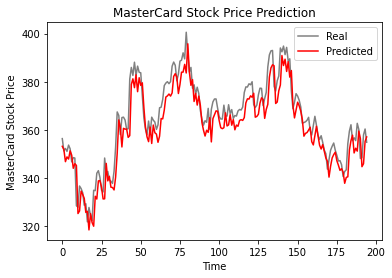

In [16]:
#According to the line plot below, the single-layered LSTM model has performed well.
plot_predictions(test_set,predicted_stock_price)

In [18]:
#The results look promising as the model got 6.70 rmse on the test dataset.
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 6.64.


#### GRU Model

In [19]:
#GRU Model
model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))

# Compiling the RNN
model_gru.compile(optimizer="RMSprop", loss="mse")

model_gru.summary()

Model: "sequential_5"

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 125)               48000     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 126       
Total params: 48,126
Trainable params: 48,126
Non-trainable params: 0
_________________________________________________________________


In [20]:
#The model has successfully trained with 50 epochs and a batch size of 32
model_gru.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
38/38 [==============================] - 3s 35ms/step - loss: 0.0192
Epoch 2/50
38/38 [==============================] - 1s 34ms/step - loss: 0.0021
Epoch 3/50
38/38 [==============================] - 1s 36ms/step - loss: 0.0016
Epoch 4/50
38/38 [==============================] - 1s 39ms/step - loss: 0.0013
Epoch 5/50
38/38 [==============================] - 1s 39ms/step - loss: 9.1870e-04
Epoch 6/50
38/38 [==============================] - 2s 40ms/step - loss: 9.9658e-04
Epoch 7/50
38/38 [==============================] - 2s 41ms/step - loss: 6.7015e-04
Epoch 8/50
38/38 [==============================] - 1s 37ms/step - loss: 7.6807e-04
Epoch 9/50
38/38 [==============================] - 1s 37ms/step - loss: 6.7032e-04
Epoch 10/50
38/38 [==============================] - 1s 39ms/step - loss: 7.1882e-04
Epoch 11/50
38/38 [==============================] - 1s 39ms/step - loss: 5.9915e-04
Epoch 12/50
38/38 [==============================] - 1s 38ms/step - loss: 5.4594e-04
Epoch

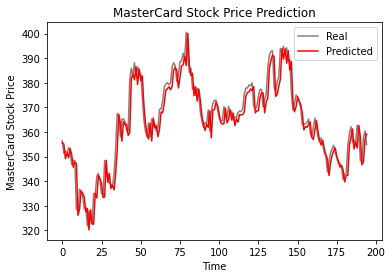

In [23]:
#GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
plot_predictions(test_set, GRU_predicted_stock_price)

In [24]:
#GRU model got 5.50 rmse on the test dataset, which is an improvement from the LSTM model
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 5.42.
